In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

pd.set_option("display.max_rows", 100)

## Data Loading

In [2]:
pd.ExcelFile("../data/deepfunding-jury.xlsx").sheet_names

['Level 1', 'Level 2', 'Level 3', 'Level 3 Scaffold-eth', 'juros']

In [3]:
sheet_name = "Level 3"

In [4]:
cols = ["name", "timestamp", "Name A", "Name B", "Choice", "Multiplier", "reasoning"];
new_cols = { "name": "Juror", "timestamp": "Timestamp", "Name A": "Project A", "Name B": "Project B" }

# Sort by juror/timestamp
df = (pd.read_excel("../data/deepfunding-jury.xlsx", sheet_name=sheet_name, parse_dates=["timestamp"])[cols]
          .rename(columns=new_cols).sort_values(by=["Juror", "Timestamp"]))

df["ReasonLen"] = df["reasoning"].str.len()
df = df.drop("reasoning", axis=1)

# Take log2 of multipliers
df["LogMultiplier"] = np.log2(df["Multiplier"])

df["LogChoiceMultiplier"] = np.where(df["Choice"] == 1, df["LogMultiplier"], -df["LogMultiplier"])

len(df)

209

In [5]:
df.Juror.nunique()

21

In [6]:
# All multipliers are >= 1
# Choice is always either 1 or 2
# Data are pre-sorted by Juror / Timestamp

df.head()

,Juror,Timestamp,Project A,Project B,Choice,Multiplier,ReasonLen,LogMultiplier,LogChoiceMultiplier
0,L3Juror 1,2025-01-06 18:06:52.450000+00:00,python/typeshed,ethereum/eth-abi,2.0,512.0,59,9.0,-9.0
1,L3Juror 1,2025-01-06 18:10:29.087000+00:00,pydantic/pydantic,ethereum/eth-typing,2.0,8.0,45,3.0,-3.0
2,L3Juror 1,2025-01-06 18:14:39.450000+00:00,ethereum/hexbytes,python/typing_extensions,1.0,256.0,61,8.0,8.0
3,L3Juror 1,2025-01-06 18:17:13.837000+00:00,ethereum/eth-abi,aio-libs/aiohttp,1.0,256.0,65,8.0,8.0
4,L3Juror 1,2025-01-06 18:17:46.900000+00:00,psf/requests,pydantic/pydantic,1.0,256.0,56,8.0,8.0


In [24]:
def savefig(title, plt):
    filename = title.replace(" ", "_").replace(":", "").replace("(", "").replace(")", "").replace(",", "")
    plt.savefig(f"../plots/{filename}.png", dpi=300, bbox_inches='tight')

## Basic Exploration

In [8]:
# Votes per juror
df.groupby("Juror").count().Choice.describe()

count    21.000000
mean      9.095238
std       6.602308
min       2.000000
25%       4.000000
50%       6.000000
75%      12.000000
max      25.000000
Name: Choice, dtype: float64

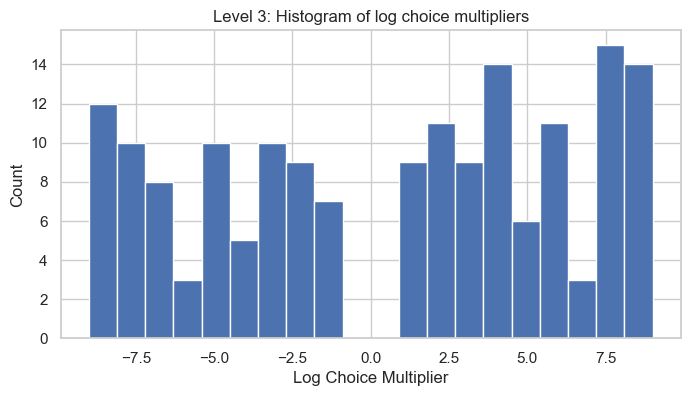

In [9]:
# Distribution of individual votes
title = f"{sheet_name}: Histogram of log choice multipliers"
ax = df[np.abs(df.LogChoiceMultiplier) < 10].LogChoiceMultiplier.hist(bins=20)
ax.set_title(title)
ax.set_xlabel("Log Choice Multiplier")
ax.set_ylabel("Count")
savefig(title, ax.figure)

## Thinking Times

In [10]:
# We infer the thinking time per vote by taking the difference between submission timestamps
def add_thinking(df):
    # Copy the dataframe
    df = df.copy()
    
    # 1. Calculate time difference between consecutive votes
    df["Thinking"] = (df["Timestamp"] - df["Timestamp"].shift(1)).dt.total_seconds() / 60
    
    # 2. Nullify thinking time for first vote of each juror (no valid previous vote)
    df.loc[df.groupby("Juror").head(1).index, "Thinking"] = np.nan
    
    # 3. Filter out extreme values (> 30 min means likely afk)
    df.loc[df["Thinking"] > 30, "Thinking"] = np.nan
    
    return df

df = add_thinking(df)
df.Thinking.describe()

count    169.000000
mean       2.203663
std        2.560283
min        0.320400
25%        0.784717
50%        1.332517
75%        2.505250
max       16.761067
Name: Thinking, dtype: float64

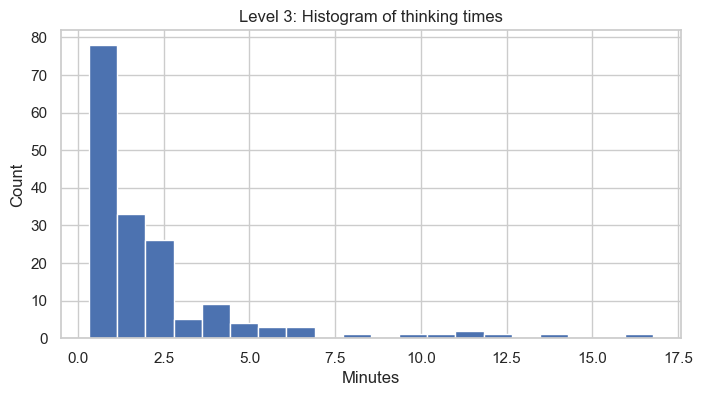

In [11]:
# We look at the overall distribution of thinking times
title = f"{sheet_name}: Histogram of thinking times"
ax = df.Thinking.hist(bins=20)
ax.set_title(title)
ax.set_xlabel("Minutes")
ax.set_ylabel("Count")
savefig(title, ax.figure)

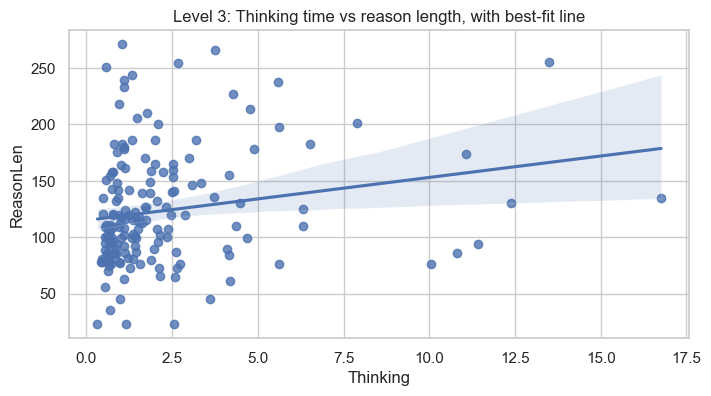

In [12]:
# We look how thinking times correlate with reason length (intuitively: more time typing -> more time between votes)
title = f"{sheet_name}: Thinking time vs reason length, with best-fit line"
sns.regplot(data=df, x="Thinking", y="ReasonLen")
plt.title(title)
savefig(title, plt)

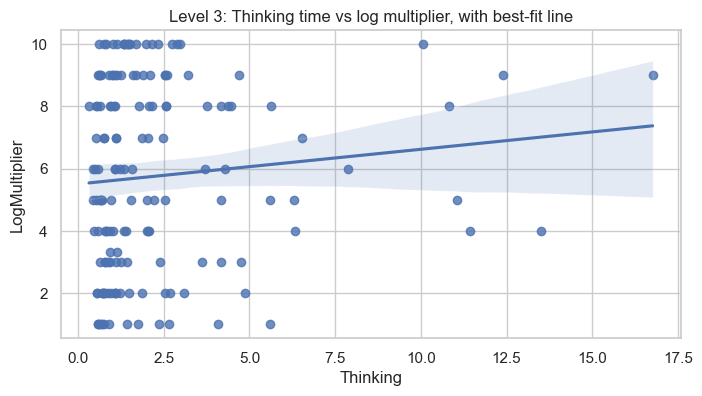

In [13]:
# We look at whether longer thinking times correlates with higher or lower multipliers
title = f"{sheet_name}: Thinking time vs log multiplier, with best-fit line"
sns.regplot(data=df, x="Thinking", y="LogMultiplier")
plt.title(title)
savefig(title, plt)

Text(0.5, 1.0, 'Level 3: Reason length vs log multiplier, with best-fit line')

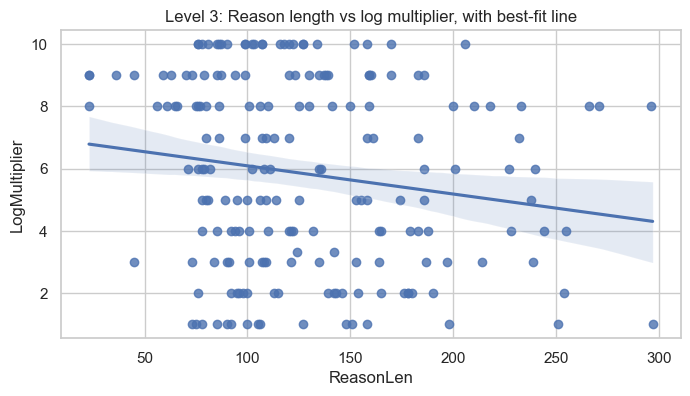

In [14]:
# We look at whether longer reasoning lengths correlates with higher or lower multipliers
sns.regplot(data=df, x="ReasonLen", y="LogMultiplier")
plt.title(f"{sheet_name}: Reason length vs log multiplier, with best-fit line")

## Juror Consistency

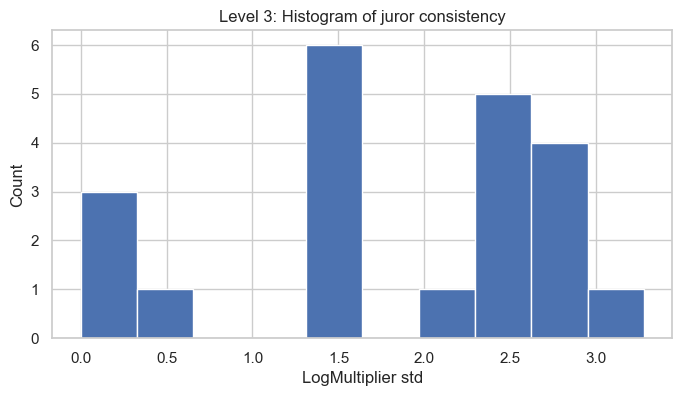

In [15]:
# We look at whether jurors tend to always give similarly-scaled ratings (low std)
title = f"{sheet_name}: Histogram of juror consistency"
ax = df.groupby("Juror").LogMultiplier.std().hist()
ax.set_title(title)
ax.set_xlabel("LogMultiplier std")
ax.set_ylabel("Count")
savefig(title, ax.figure)

## Project Consistency

In [16]:
# Let's look at how different jurors voted on the same project pair
stats = df.groupby(["Project A", "Project B"]).Choice.describe()
stats.head()

,,count,mean,std,min,25%,50%,75%,max
Project A,Project B,,,,,,,,
Amanieu/parking_lot,RustCrypto/hashes,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
ApeWorX/ethpm-types,ApeWorX/eth-pydantic-types,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
ApeWorX/evm-trace,ApeWorX/eip712,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ApeWorX/evmchains,pandas-dev/pandas,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
DefinitelyTyped/DefinitelyTyped,isaacs/node-glob,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0


In [17]:
# First, let's see how many times any given pair was voted on 
stats["count"].value_counts()

count
1.0    104
2.0     28
0.0     10
3.0      6
4.0      2
5.0      1
Name: count, dtype: int64

In [18]:
# Now let's see how often two jurors agreed on the valence of a pair
# We calculate this through the std of the choices -- since choice is 1 or 2, std is either 0 (agreement) or .7 (disagree)
# This only works for cases where there are exactly 2 votes, so we only consider those cases
counts2 = stats[stats["count"] == 2]["std"].value_counts()
counts2

std
0.000000    25
0.707107     3
Name: count, dtype: int64

In [19]:
# What percentage of the time did two jurors agree?
counts2[0] / counts2.sum()

np.float64(0.8928571428571429)

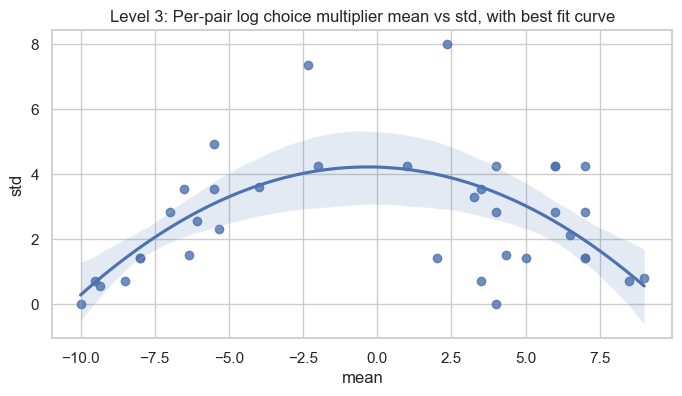

In [20]:
# Let's see how much agreement jurors have over their multipliers
title = f"{sheet_name}: Per-pair log choice multiplier mean vs std, with best fit curve"
sns.regplot(data=df.groupby(["Project A", "Project B"]).LogChoiceMultiplier.describe(), x="mean", y="std", order=2)
plt.title(title)
savefig(title, plt)

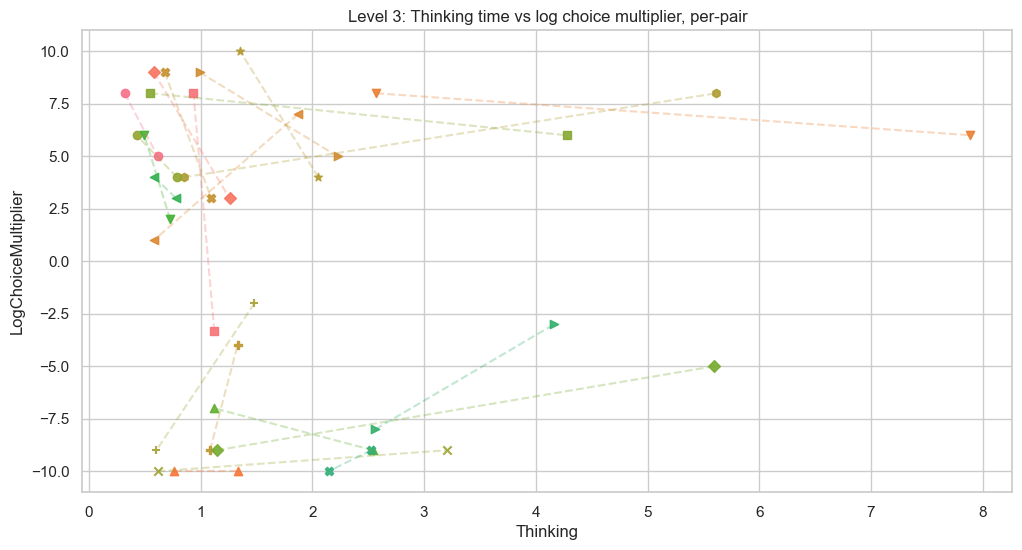

In [25]:
# In this more involved plot, we visualize how thinking time relates to the multiplier for projects receiving two judgments
# We want to see whether, for a given project, the juror who spent more time thinking reported a higher or lower multiple

from itertools import cycle

plt.figure(figsize=(12, 6))

colors = iter(sns.color_palette("husl", 50))
markers = cycle(["o", "s", "D", "^", "v", "<", ">", "X", "P", "*", "h", "+", "x"])

# We group by project pair, for pairs which received exactly two votes
votes2 = df.dropna().groupby(["Project A", "Project B"]).size() == 2
grouped2 = (df.dropna()
            .set_index(["Project A", "Project B"])
            .loc[votes2[votes2].index]
            .reset_index()
            .groupby(["Project A", "Project B"]))

# Plot each group
for (proj_a, proj_b), group_df in grouped2:
    label = f"{proj_a} | {proj_b}"
    color = next(colors)
    marker = next(markers)

    plt.scatter(
        group_df["Thinking"], group_df["LogChoiceMultiplier"],
        alpha=0.9,
        label=label,
        color=color,
        marker=marker
    )

    plt.plot(
        group_df["Thinking"], group_df["LogChoiceMultiplier"],
        color=color,
        alpha=0.3,
        linestyle="--"
    )

title = f"{sheet_name}: Thinking time vs log choice multiplier, per-pair"
plt.xlabel("Thinking")
plt.ylabel("LogChoiceMultiplier")
plt.title(title)
savefig(title, plt)
plt.show()